# <font color='darkblue'> Part 2 : Problem Formulation / Patient Similarity Network Generation </font>

In this section we will formulate a task to predict if an individual in the Generation Scotland dataset is a smoker or not. We will formulate the task using the Patient Similarity Networks generated earlier. We will also highlight that not every network is created equal. 

Networks are flexible and we can leverage/incorporate additional informative information. We have used the [EWAS Catalog](https://www.ewascatalog.org/) to identify CpG sites affected by smoking. We will compare the effectiveness of GNN's when incorporating external informative versus doing a direct correlation network. 

## <font color='darkblue'>Import Functions and Packages </font>

In [1]:
import pickle
import pandas as pd
import numpy as np
import networkx as nx
from palettable import wesanderson
import sys
sys.path.insert(0 , './../')
from functions import *

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


## <font color='darkblue'>Import and Process Generation Scotland Data</font>

First we will load the data from Generation Scotland and create labels for individuals who have smoked before using the 'pack_years' feature

In [2]:
# Load the data using pickle
with open('./../data/ISMB_GS_Data.pkl' , 'rb') as file : 
    loaded_data = pd.read_pickle(file)

In [3]:
w1 = loaded_data['DNAm_w1'].T.dropna() # we are only working with Wave 1 patients for this task
phenotypes = loaded_data['Phenotypes'].set_index('Sample_SentrixID').loc[w1.index] # get the phenotypes for the wave 1 patients

In [4]:
# Create a new column in the phenotypes dataframe that categorizes patients as either smokers or non-smokers
def smoking_cat(row) : 
    if row['pack_years'] == 0 :
        return 'Non-Smoker'
    else :
        return 'Smoker'

phenotypes['Smoking'] = phenotypes.apply(smoking_cat , axis = 1) # apply the function to the dataframe

In [5]:
# For efficiency of graph training and learning we will downsample the dataset size to 1000 patients
never_smoked = phenotypes[phenotypes['Smoking'] == 'Non-Smoker'].sample(500) # sample 500 non-smokers
smoked = phenotypes[phenotypes['Smoking'] == 'Smoker'].sample(500) # sample 500 smokers

phenotypes = pd.concat([never_smoked , smoked]) # combine the two dataframes
w1 = w1.loc[phenotypes.index] # filter the methylation data to only include the patients in the downsampled phenotypes dataframe

Text(0.5, 1.0, 'Distribution of Smokers and Non-Smokers')

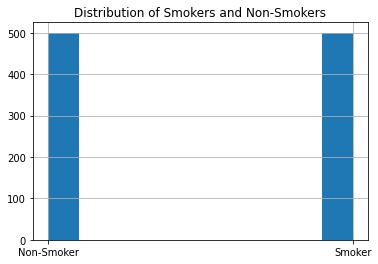

In [6]:
phenotypes['Smoking'].hist() # plot the distribution of smokers and non-smokers
plt.title('Distribution of Smokers and Non-Smokers')

In [7]:
# Import Patient Similarity Network from earlier



## <font color='darkblue'> EWAS Network Generation </font>

### <font color='darkblue'>Get a list of Smoking related CpG sites from the [EWAS Catalog](https://www.ewascatalog.org/)</font>

In this case we are looking at the smoking phenotype in a cohort from Generation Scotland. 

We have previously downloaded as tsv file for Smoking related CpG sites, but you can generate your own using the above link also.

Here we will extract the CpG's and related genes which we will use to build our network.

In [8]:
df = pd.read_csv('./../data/smoking.tsv' , delimiter='\t') #Tab seperated document from EWAS

In [9]:
df.head()

,author,consortium,pmid,date,trait,efo,analysis,source,outcome,exposure,...,chrpos,chr,pos,gene,type,beta,se,p,details,study_id
0,Sikdar S,CHARGE,31536415,2019-09-19,Smoking,"EFO_0009115, EFO_0006527, EFO_0004318",random effects meta-analysis,Table S2,DNA methylation,Smoking,...,chr2:233284934,2,233284934,-,Island,-0.08545,0.00131,0.0,NaN,31536415_Sikdar-S_smoking_random_effects_meta-...
1,Sikdar S,CHARGE,31536415,2019-09-19,Smoking,"EFO_0009115, EFO_0006527, EFO_0004318",random effects meta-analysis,Table S2,DNA methylation,Smoking,...,chr19:17000585,19,17000585,F2RL3,North shore,-0.07233,0.00129,0.0,NaN,31536415_Sikdar-S_smoking_random_effects_meta-...
2,Sikdar S,CHARGE,31536415,2019-09-19,Smoking,"EFO_0009115, EFO_0006527, EFO_0004318",random effects meta-analysis,Table S2,DNA methylation,Smoking,...,chr5:373378,5,373378,AHRR,North shore,-0.03138,0.00078,0.0,NaN,31536415_Sikdar-S_smoking_random_effects_meta-...
3,Sikdar S,CHARGE,31536415,2019-09-19,Smoking,"EFO_0009115, EFO_0006527, EFO_0004318",random effects meta-analysis,Table S2,DNA methylation,Smoking,...,chr2:233284402,2,233284402,-,Island,-0.07381,0.00132,0.0,NaN,31536415_Sikdar-S_smoking_random_effects_meta-...
4,Sikdar S,CHARGE,31536415,2019-09-19,Smoking,"EFO_0009115, EFO_0006527, EFO_0004318",random effects meta-analysis,Table S2,DNA methylation,Smoking,...,chr6:30720080,6,30720080,-,Open sea,-0.08558,0.00159,0.0,NaN,31536415_Sikdar-S_smoking_random_effects_meta-...


### <font color='darkblue'>Patient Similarity Network Generation</font>

In [10]:
'''
#################################################
                YOUR CODE HERE
#################################################

We want to include the most informative CpG sites, so we will only include CpG sites that have been annotated multiple times with smoking

1. Count the number of times a CpG site is present in the smoking.tcv dataset
2. If a CpG is present in the dataset more than 10 times add it to the list common_annotated_cpgs
3. Filter the methylation data to only include the CpG sites in common_annotated_cpgs
4. Call the new dataframe w1_filt

'''
common_annotated_cpgs = list(df['cpg'].value_counts()[df['cpg'].value_counts() > 10].index) 

cpgs = set(common_annotated_cpgs) & set(w1.columns)

w1_filt = w1.loc[ : , list(cpgs)]

In [11]:
'''
#################################################
                YOUR CODE HERE
#################################################

We want to create our patient similarity matrix using the filtered methylation data
We will use biweight midcorrelation to calculate the similarity between patients 
The function for this is given as abs_bicorr

'''
patient_similarity_matrix = abs_bicorr(w1_filt.T)

Non-Smoker : 0 
Smoker : 1


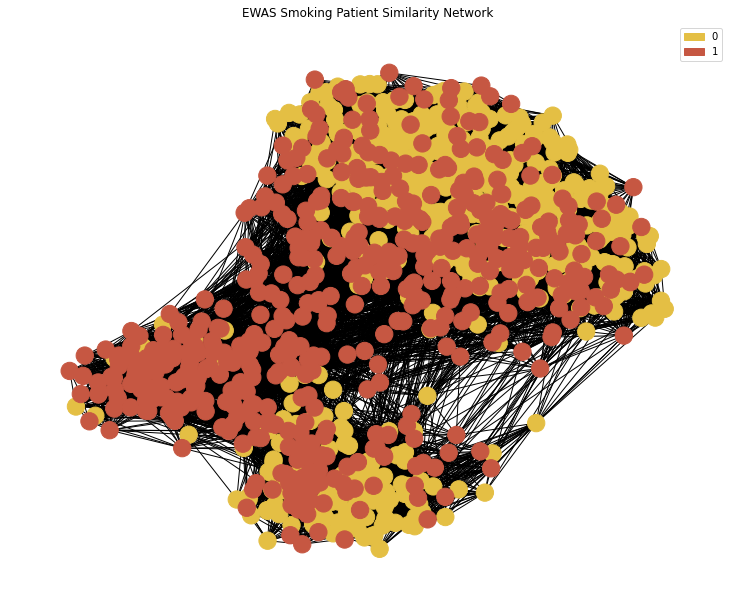

In [12]:
node_colour = phenotypes['Smoking'].astype('category').cat.set_categories(wesanderson.FantasticFox2_5.hex_colors , rename=True) # set the colours for the nodes

print(f"{phenotypes['Smoking'].astype('category').cat.categories[0]} : 0 \n{phenotypes['Smoking'].astype('category').cat.categories[1]} : 1") # print the mapping of the colours to the categories

G = plot_knn_network(patient_similarity_matrix , 25 , phenotypes['Smoking'] , node_colours=node_colour) # plot the network
plt.title('EWAS Smoking Patient Similarity Network')
legend_handles = gen_graph_legend(node_colour , G , 'label') # generate the legend
plt.legend(handles = legend_handles)
plt.show()

## <font color='darkblue'>Save Network and Data for GNN Learning </font>

In [13]:
# Put the data in a single dictionary
data = {'Feat' : w1 , 'phenotypes' : phenotypes , 'PSN_raw' : [] , 'PSN_EWAS' : G}

# File path to save the pickle file
file_path = './../data/GCN_Data.pkl'

# Save data to a pickle file
with open(file_path, 'wb') as f:
    pickle.dump(data, f)